In [ ]:
# ============================================================================
# LSTM USD/PEN - NOTEBOOK COMPLETO PARA GOOGLE COLAB PRO+
# ============================================================================
# ✅ Con checkpoints automáticos
# ✅ Optimizado para GPU T4/A100/V100
# ✅ Homogéneo con los otros 7 modelos
# ✅ Listo para copiar/pegar
# ============================================================================
# INSTRUCCIONES:
# 1. Crear nuevo notebook en Colab
# 2. Runtime > Change runtime type > GPU
# 3. Copiar cada CELDA y pegarla en orden
# 4. Ejecutar secuencialmente
# ============================================================================

# ============================================================================
# CELDA 1: VERIFICAR GPU Y SETUP INICIAL
# ============================================================================

import torch
import sys
from pathlib import Path

print("="*80)
print("🚀 LSTM USD/PEN - GOOGLE COLAB PRO+ CON CHECKPOINTS")
print("="*80)

# Verificar GPU
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"\n✅ GPU DISPONIBLE: {gpu_name}")
    print(f"   Memoria: {gpu_memory:.1f} GB")
    print(f"   CUDA Version: {torch.version.cuda}")
else:
    print("\n⚠️ NO HAY GPU DISPONIBLE - Usando CPU")
    print("   👉 Ir a: Runtime > Change runtime type > GPU")

print(f"\nPython: {sys.version}")
print(f"PyTorch: {torch.__version__}")

🚀 LSTM USD/PEN - GOOGLE COLAB PRO+ CON CHECKPOINTS

✅ GPU DISPONIBLE: NVIDIA A100-SXM4-80GB
   Memoria: 85.2 GB
   CUDA Version: 12.6

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch: 2.9.0+cu126


In [ ]:
# ============================================================================
# CELDA 2: INSTALAR DEPENDENCIAS
# ============================================================================

print("\n" + "="*80)
print("📦 INSTALANDO DEPENDENCIAS")
print("="*80)

# Instalar Optuna
try:
    import optuna
    print(f"✅ Optuna {optuna.__version__} ya instalado")
except ImportError:
    print("⏳ Instalando Optuna...")
    !pip install -q optuna
    import optuna
    print(f"✅ Optuna {optuna.__version__} instalado")

# Verificar otras dependencias
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("\n✅ Todas las dependencias listas")


📦 INSTALANDO DEPENDENCIAS
⏳ Instalando Optuna...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 31.2 MB/s eta 0:00:00
✅ Optuna 4.6.0 instalado

✅ Todas las dependencias listas


In [ ]:
# ============================================================================
# CELDA 3: MONTAR GOOGLE DRIVE
# ============================================================================

print("\n" + "="*80)
print("📁 MONTANDO GOOGLE DRIVE")
print("="*80)

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Configurar paths para Colab
DRIVE_BASE = Path('/content/drive/MyDrive/Colab_Outputs')
OUTPUT_DIR = DRIVE_BASE / 'LSTM_h1_USD_PEN'
PREDICTIONS_DIR = DRIVE_BASE / 'predictions_dump'
CHECKPOINT_DIR = DRIVE_BASE / 'LSTM_checkpoints'
OOF_DIR = DRIVE_BASE / 'oof_predictions'  # ← NUEVO

# Crear directorios
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
PREDICTIONS_DIR.mkdir(parents=True, exist_ok=True)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
OOF_DIR.mkdir(parents=True, exist_ok=True)  # ← NUEVO

print(f"\n✅ Drive montado correctamente")
print(f"   Output: {OUTPUT_DIR}")
print(f"   Predictions: {PREDICTIONS_DIR}")
print(f"   Checkpoints: {CHECKPOINT_DIR}")
print(f"   OOF: {OOF_DIR}")  # ← NUEVO


📁 MONTANDO GOOGLE DRIVE
Mounted at /content/drive

✅ Drive montado correctamente
   Output: /content/drive/MyDrive/Colab_Outputs/LSTM_h1_USD_PEN
   Predictions: /content/drive/MyDrive/Colab_Outputs/predictions_dump
   Checkpoints: /content/drive/MyDrive/Colab_Outputs/LSTM_checkpoints
   OOF: /content/drive/MyDrive/Colab_Outputs/oof_predictions


In [ ]:
# ============================================================================
# CELDA 4: CONFIGURACIÓN GLOBAL
# ============================================================================

class Config:
    """Configuración estandarizada para comparabilidad"""

    # Reproducibilidad
    RANDOM_STATE = 42

    # Splits (NO NEGOCIABLE)
    N_HOLDOUT = 60          # ✅ CRÍTICO: Exactamente 60 días
    STEP_SIZE = 21          # ✅ CRÍTICO: Para walk-forward
    MIN_TRAIN = 252

    # Target
    TARGET_COL = 'PEN_log_ret'  # ✅ LOG RETURNS (Grupo B)
    H_FORECAST = 1

    # Features exógenas (13 EXACTAS)
    TECHNICAL_FEATURES = ['GARCH_vol', 'RSI', 'MACD_line']
    MACRO_FX_FEATURES = [
        'MXN_log_ret_lag_1', 'CLP_log_ret_lag_1',
        'COBRE_log_ret_lag_1', 'MXPE_log_ret_lag_1',
        'DXY_diff_lag_1', 'UST10Y_diff_lag_1'
    ]
    TEMPORAL_FEATURES = [
        'month_sin', 'month_cos',
        'day_of_week_sin', 'day_of_week_cos'
    ]
    ALL_EXOG_FEATURES = TECHNICAL_FEATURES + MACRO_FX_FEATURES + TEMPORAL_FEATURES

    # Tuning
    N_TRIALS = 75
    TIMEOUT = 3600  # 1 hora

    # Checkpoints
    ENABLE_CHECKPOINTS = True
    CHECKPOINT_FREQUENCY = 5  # Guardar cada 5 trials
    CHECKPOINT_DIR = CHECKPOINT_DIR

    # Device
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Baselines
    BASELINES = {
        'ARX': {'DA': 51.67, 'MASE': 0.9398},
        'NHITS': {'DA': 53.66, 'MASE': 0.9350},
        'NBEATSX': {'DA': 45.00, 'MASE': 0.9442}
    }

# Configurar seeds
torch.manual_seed(Config.RANDOM_STATE)
np.random.seed(Config.RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(Config.RANDOM_STATE)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print("\n✅ Configuración cargada")
print(f"   Device: {Config.DEVICE}")
print(f"   Holdout: {Config.N_HOLDOUT} días")
print(f"   Exógenas: {len(Config.ALL_EXOG_FEATURES)}")
print(f"   Checkpoints: {'Activados ✅' if Config.ENABLE_CHECKPOINTS else 'Desactivados'}")


✅ Configuración cargada
   Device: cuda
   Holdout: 60 días
   Exógenas: 13
   Checkpoints: Activados ✅


In [ ]:
# ============================================================================
# CELDA 5: CHECKPOINT MANAGER + SAVE_OOF_PREDICTIONS (MODIFICADO)
# ============================================================================

class CheckpointManager:
    """Gestor de checkpoints para tuning y entrenamiento"""

    def __init__(self, checkpoint_dir=Config.CHECKPOINT_DIR):
        self.checkpoint_dir = Path(checkpoint_dir)
        self.checkpoint_dir.mkdir(parents=True, exist_ok=True)

        self.optuna_checkpoint = self.checkpoint_dir / 'optuna_study.pkl'
        self.best_model_checkpoint = self.checkpoint_dir / 'best_model.pth'
        self.config_checkpoint = self.checkpoint_dir / 'last_config.json'
        self.progress_log = self.checkpoint_dir / 'progress.json'

    def save_optuna_study(self, study, trial_number):
        """Guardar study de Optuna"""
        checkpoint_data = {
            'study': study,
            'trial_number': trial_number,
            'best_value': study.best_value if len(study.trials) > 0 else None,
            'best_params': study.best_params if len(study.trials) > 0 else None,
            'n_trials': len(study.trials),
            'timestamp': datetime.now().isoformat()
        }

        with open(self.optuna_checkpoint, 'wb') as f:
            pickle.dump(checkpoint_data, f)

        print(f"\n💾 [CHECKPOINT] Study guardado (trial {trial_number})")

    def load_optuna_study(self):
        """Cargar study de Optuna"""
        if not self.optuna_checkpoint.exists():
            return None

        try:
            with open(self.optuna_checkpoint, 'rb') as f:
                checkpoint_data = pickle.load(f)

            print(f"\n📂 [CHECKPOINT] Encontrado:")
            print(f"   Trials: {checkpoint_data['n_trials']}")
            print(f"   Mejor DA: {checkpoint_data['best_value']:.2f}%")
            print(f"   Fecha: {checkpoint_data['timestamp']}")

            return checkpoint_data
        except Exception as e:
            print(f"⚠️ Error cargando checkpoint: {e}")
            return None

    def save_model_checkpoint(self, model, config, epoch, loss, metrics):
        """Guardar checkpoint del modelo"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'config': config,
            'loss': loss,
            'metrics': metrics,
            'timestamp': datetime.now().isoformat()
        }

        torch.save(checkpoint, self.best_model_checkpoint)
        print(f"💾 [CHECKPOINT] Modelo guardado (epoch {epoch}, loss {loss:.6f})")

    def load_model_checkpoint(self):
        """Cargar checkpoint del modelo"""
        if not self.best_model_checkpoint.exists():
            return None

        try:
            checkpoint = torch.load(self.best_model_checkpoint)
            print(f"\n📂 [CHECKPOINT] Modelo encontrado (epoch {checkpoint['epoch']})")
            return checkpoint
        except Exception as e:
            print(f"⚠️ Error cargando modelo: {e}")
            return None

    def save_progress(self, step, info):
        """Guardar progreso general"""
        progress = {
            'step': step,
            'info': info,
            'timestamp': datetime.now().isoformat()
        }

        if self.progress_log.exists():
            with open(self.progress_log, 'r') as f:
                all_progress = json.load(f)
        else:
            all_progress = []

        all_progress.append(progress)

        with open(self.progress_log, 'w') as f:
            json.dump(all_progress, f, indent=2)

    def clear_checkpoints(self):
        """Limpiar todos los checkpoints"""
        for file in [self.optuna_checkpoint, self.best_model_checkpoint,
                     self.config_checkpoint, self.progress_log]:
            if file.exists():
                file.unlink()
        print("🗑️ Checkpoints limpiados")

    def ask_resume(self):
        """Preguntar si continuar desde checkpoint"""
        if not self.optuna_checkpoint.exists():
            return False

        checkpoint = self.load_optuna_study()
        if checkpoint is None:
            return False

        print("\n" + "="*80)
        print("📁 CHECKPOINT DETECTADO")
        print("="*80)
        response = input("\n¿Continuar desde checkpoint? (y/n): ").lower().strip()

        if response == 'y':
            print("✅ Continuando desde checkpoint...")
            return True
        else:
            print("🔄 Empezando desde cero")
            return False


# ═══════════════════════════════════════════════════════════════════════════
# ★★★ NUEVA FUNCIÓN: save_oof_predictions() ★★★
# ═══════════════════════════════════════════════════════════════════════════

def save_oof_predictions(predictions, dates, actuals, model_name,
                         prediction_type, metadata, output_dir=OOF_DIR):
    """
    Guardar predicciones Out-of-Fold (OOF) para el meta-learner.

    Args:
        predictions: np.array con predicciones OOF
        dates: lista/array con fechas correspondientes
        actuals: np.array con valores reales
        model_name: nombre del modelo (ej: 'LSTM')
        prediction_type: 'log_returns' o 'levels'
        metadata: dict con información adicional
        output_dir: directorio de salida
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    # Crear DataFrame OOF
    df_oof = pd.DataFrame({
        'ds': dates,
        'y_pred': predictions,
        'y_real': actuals,
        'model': model_name,
        'type': prediction_type
    })

    # Guardar CSV
    csv_path = output_dir / f'train_oof_{model_name}.csv'
    df_oof.to_csv(csv_path, index=False)

    # Guardar metadata
    metadata_path = output_dir / f'train_oof_{model_name}_metadata.json'
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2, default=str)

    print(f"\n{'='*60}")
    print(f"💾 OOF PREDICTIONS GUARDADAS")
    print(f"{'='*60}")
    print(f"   Archivo CSV:  {csv_path}")
    print(f"   Metadata:     {metadata_path}")
    print(f"   Observaciones: {len(predictions)}")
    print(f"   Modelo:        {model_name}")
    print(f"   Tipo:          {prediction_type}")

    # Validaciones
    n_zeros = np.sum(predictions == 0)
    n_nans = np.sum(np.isnan(predictions))

    if n_zeros > 0:
        print(f"   ⚠️ Zeros:     {n_zeros}")
    if n_nans > 0:
        print(f"   ⚠️ NaNs:      {n_nans}")

    return csv_path


print("✅ CheckpointManager y save_oof_predictions definidos")


✅ CheckpointManager y save_oof_predictions definidos


In [ ]:
# ============================================================================
# CELDA 6: FEATURE ENGINEERING
# ============================================================================

class FeatureEngineer:
    """Feature engineering anti-leakage"""

    @staticmethod
    def calculate_garch_vol(returns, window=21):
        """GARCH(1,1) volatility"""
        vol = returns.rolling(window).std()
        return vol

    @staticmethod
    def calculate_rsi(prices, period=14):
        """Relative Strength Index"""
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return (rsi - 50) / 50

    @staticmethod
    def calculate_macd(prices, fast=12, slow=26):
        """MACD line"""
        ema_fast = prices.ewm(span=fast).mean()
        ema_slow = prices.ewm(span=slow).mean()
        macd = ema_fast - ema_slow
        return macd / prices

    @staticmethod
    def cyclical_encoding(df, col_name, max_val):
        """Encoding cíclico sin-cos"""
        if col_name == 'month':
            values = df.index.month
        elif col_name == 'day_of_week':
            values = df.index.dayofweek
        elif col_name == 'quarter':
            values = df.index.quarter
        else:
            raise ValueError(f"Unknown temporal column: {col_name}")

        df[f'{col_name}_sin'] = np.sin(2 * np.pi * values / max_val)
        df[f'{col_name}_cos'] = np.cos(2 * np.pi * values / max_val)
        return df

    def create_all_features(self, df):
        """Crear TODAS las features SIN DATA LEAKAGE"""
        df = df.copy()

        print("\n🔧 Feature Engineering...")

        # 1. Target
        df['PEN_log_ret'] = np.log(df['PEN'] / df['PEN'].shift(1))

        # 2. Técnicas
        prices_shifted = df['PEN'].shift(1)
        returns_shifted = df['PEN_log_ret'].shift(1)

        df['GARCH_vol'] = self.calculate_garch_vol(returns_shifted)
        df['RSI'] = self.calculate_rsi(prices_shifted)
        df['MACD_line'] = self.calculate_macd(prices_shifted)

        # 3. Macro/FX
        for col in ['MXN', 'CLP', 'COBRE', 'MXPE']:
            if col in df.columns:
                df[f'{col}_log_ret'] = np.log(df[col] / df[col].shift(1))
                df[f'{col}_log_ret_lag_1'] = df[f'{col}_log_ret'].shift(1)

        # 4. Tasas
        for col in ['DXY', 'UST10Y']:
            if col in df.columns:
                df[f'{col}_diff'] = df[col].diff()
                df[f'{col}_diff_lag_1'] = df[f'{col}_diff'].shift(1)

        # 5. Temporales
        df = self.cyclical_encoding(df, 'month', 12)
        df = self.cyclical_encoding(df, 'day_of_week', 7)

        # 6. Drop NaNs
        df = df.dropna()

        # 7. Validar anti-leakage
        self._validate_no_leakage(df)

        print(f"✅ Features creadas: {df.shape[1]} columnas")
        return df

    def _validate_no_leakage(self, df):
        """Validar que no haya leakage"""
        print("\n🔍 VALIDACIÓN ANTI-LEAKAGE:")
        for feat in Config.ALL_EXOG_FEATURES:
            if feat in df.columns:
                corr = df['PEN_log_ret'].corr(df[feat])
                print(f"  {feat:25s} | corr = {corr:6.4f}")
                if abs(corr) > 0.99:
                    raise ValueError(f"⚠️ LEAKAGE: {feat} corr={corr:.4f}")
        print("✅ No leakage detected\n")

print("✅ FeatureEngineer definido")

✅ FeatureEngineer definido


In [ ]:
# ============================================================================
# CELDA 7: PYTORCH DATASET Y ARQUITECTURA
# ============================================================================

class LSTMDataset(Dataset):
    """Dataset para LSTM con secuencias"""

    def __init__(self, data, target_col, seq_length, exog_features=None):
        self.seq_length = seq_length

        target_values = data[target_col].values

        if exog_features and len(exog_features) > 0:
            missing = [f for f in exog_features if f not in data.columns]
            if missing:
                raise ValueError(f"Missing features: {missing}")

            exog_values = data[exog_features].values
            all_features = np.column_stack([target_values[:-1], exog_values[1:]])
        else:
            all_features = target_values[:-1].reshape(-1, 1)

        self.sequences = []
        self.targets = []

        for i in range(seq_length, len(target_values)):
            seq = all_features[i-seq_length:i]
            label = target_values[i]
            self.sequences.append(seq)
            self.targets.append(label)

        self.sequences = torch.FloatTensor(np.array(self.sequences))
        self.targets = torch.FloatTensor(np.array(self.targets))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]


class LSTMForecaster(nn.Module):
    """LSTM para forecasting USD/PEN h=1"""

    def __init__(self, input_size, hidden_size, num_layers, dropout=0.0, output_size=1):
        super(LSTMForecaster, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True,
            bidirectional=False
        )

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]
        output = self.fc(last_output)
        return output

print("✅ LSTMDataset y LSTMForecaster definidos")


✅ LSTMDataset y LSTMForecaster definidos


In [ ]:
# ============================================================================
# CELDA 8: MÉTRICAS
# ============================================================================

class Metrics:
    """Métricas estandarizadas: DA y MASE"""

    @staticmethod
    def directional_accuracy(y_true, y_pred):
        """Directional Accuracy (%)"""
        correct = np.sum((y_true > 0) == (y_pred > 0))
        da = 100 * correct / len(y_true)
        return da

    @staticmethod
    def mase(y_true, y_pred, y_train):
        """Mean Absolute Scaled Error"""
        mae = np.mean(np.abs(y_true - y_pred))
        naive_mae = np.mean(np.abs(np.diff(y_train)))
        mase = mae / naive_mae
        return mase

    @staticmethod
    def mae(y_true, y_pred):
        """Mean Absolute Error"""
        return np.mean(np.abs(y_true - y_pred))

print("✅ Metrics definido")


✅ Metrics definido


In [ ]:
# ============================================================================
# CELDA 9: LSTM TUNER CON CHECKPOINTS
# ============================================================================

class LSTMTuner:
    """Hyperparameter tuning con checkpoints"""

    def __init__(self, checkpoint_manager=None):
        self.device = Config.DEVICE
        self.best_model = None

        if checkpoint_manager is None and Config.ENABLE_CHECKPOINTS:
            self.checkpoint_manager = CheckpointManager()
        else:
            self.checkpoint_manager = checkpoint_manager

        self.trial_counter = 0

    def _create_model(self, input_size, hidden_size, num_layers, dropout):
        model = LSTMForecaster(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout
        ).to(self.device)
        return model

    def _train_model(self, model, train_loader, epochs, learning_rate, patience=10):
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()

        best_loss = float('inf')
        patience_counter = 0

        model.train()
        for epoch in range(epochs):
            total_loss = 0

            for batch_x, batch_y in train_loader:
                batch_x = batch_x.to(self.device)
                batch_y = batch_y.to(self.device)

                optimizer.zero_grad()
                outputs = model(batch_x).squeeze()
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)

            if avg_loss < best_loss:
                best_loss = avg_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    break

        return model

    def _rolling_forecast(self, model, train_df, valid_df, seq_length, exog_features):
        model.eval()
        predictions = []

        with torch.no_grad():
            for i in range(len(valid_df)):
                if i == 0:
                    context = train_df.copy()
                else:
                    context = pd.concat([train_df, valid_df.iloc[:i]])

                dataset = LSTMDataset(context, Config.TARGET_COL, seq_length, exog_features)

                if len(dataset) > 0:
                    last_seq = dataset.sequences[-1:].to(self.device)
                    pred = model(last_seq).cpu().item()
                    predictions.append(pred)
                else:
                    predictions.append(0.0)

        return np.array(predictions)

    def _checkpoint_callback(self, study, trial):
        """Callback para checkpoints"""
        self.trial_counter += 1

        if self.checkpoint_manager and (self.trial_counter % Config.CHECKPOINT_FREQUENCY == 0):
            self.checkpoint_manager.save_optuna_study(study, self.trial_counter)
            self.checkpoint_manager.save_progress(
                step='tuning',
                info={
                    'trial': self.trial_counter,
                    'best_value': study.best_value,
                    'best_params': study.best_params
                }
            )

    def _objective(self, trial, train_inner, valid_df):
        seq_length = trial.suggest_categorical('seq_length', [21, 42, 63, 126, 252])
        hidden_size = trial.suggest_categorical('hidden_size', [32, 64, 128])
        num_layers = trial.suggest_categorical('num_layers', [1, 2, 3])
        dropout = trial.suggest_categorical('dropout', [0.0, 0.1, 0.2, 0.3])
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

        try:
            train_dataset = LSTMDataset(
                train_inner,
                Config.TARGET_COL,
                seq_length,
                Config.ALL_EXOG_FEATURES
            )

            if len(train_dataset) < batch_size:
                return 0.0

            train_loader = DataLoader(
                train_dataset,
                batch_size=batch_size,
                shuffle=True,
                num_workers=2 if torch.cuda.is_available() else 0,
                pin_memory=True if torch.cuda.is_available() else False
            )

            input_size = 1 + len(Config.ALL_EXOG_FEATURES)
            model = self._create_model(input_size, hidden_size, num_layers, dropout)
            model = self._train_model(model, train_loader, epochs=50, learning_rate=learning_rate)

            predictions = self._rolling_forecast(
                model, train_inner, valid_df, seq_length, Config.ALL_EXOG_FEATURES
            )

            y_true = valid_df[Config.TARGET_COL].values[-len(predictions):]
            da = Metrics.directional_accuracy(y_true, predictions)

            if da > 70 or da < 30:
                return 0.0

            return da

        except Exception as e:
            print(f"⚠️ Trial failed: {e}")
            return 0.0

    def tune(self, train_df, n_trials=Config.N_TRIALS, timeout=Config.TIMEOUT,
             resume_from_checkpoint=None):
        """Ejecutar tuning con checkpoints"""

        print("\n" + "="*80)
        print("🎯 HYPERPARAMETER TUNING CON CHECKPOINTS")
        print("="*80)

        # Split interno
        split_idx = int(len(train_df) * 0.8)
        train_inner = train_df.iloc[:split_idx].copy()
        valid_df = train_df.iloc[split_idx:].copy()

        print(f"\nSplit interno:")
        print(f"  Train: {train_inner.shape[0]} samples")
        print(f"  Valid: {valid_df.shape[0]} samples")

        # Verificar checkpoint
        study = None
        initial_trials = 0

        if Config.ENABLE_CHECKPOINTS and self.checkpoint_manager:
            if resume_from_checkpoint is None:
                resume = self.checkpoint_manager.ask_resume()
            else:
                resume = resume_from_checkpoint

            if resume:
                checkpoint_data = self.checkpoint_manager.load_optuna_study()
                if checkpoint_data:
                    study = checkpoint_data['study']
                    initial_trials = checkpoint_data['n_trials']
                    self.trial_counter = initial_trials
                    print(f"✅ Resumiendo desde trial {initial_trials}")

        # Crear study si no existe
        if study is None:
            study = optuna.create_study(
                direction='maximize',
                sampler=TPESampler(seed=Config.RANDOM_STATE)
            )
            print("🆕 Nuevo estudio creado")

        # Trials restantes
        remaining_trials = max(0, n_trials - initial_trials)

        if remaining_trials == 0:
            print(f"✅ Ya completados {n_trials} trials")
            return {
                'best_config': study.best_params,
                'best_metrics': {'DA_valid': study.best_value},
                'study': study
            }

        print(f"\n🔄 Ejecutando {remaining_trials} trials...")

        # Optimizar
        study.optimize(
            lambda trial: self._objective(trial, train_inner, valid_df),
            n_trials=remaining_trials,
            timeout=timeout,
            callbacks=[self._checkpoint_callback] if Config.ENABLE_CHECKPOINTS else None,
            show_progress_bar=True
        )

        # Guardar checkpoint final
        if Config.ENABLE_CHECKPOINTS and self.checkpoint_manager:
            self.checkpoint_manager.save_optuna_study(study, len(study.trials))

        print(f"\n✅ Tuning completado!")
        print(f"   Total trials: {len(study.trials)}")
        print(f"   Best DA: {study.best_value:.2f}%")
        print(f"\n📊 Best config:")
        for key, value in study.best_params.items():
            print(f"   {key}: {value}")

        return {
            'best_config': study.best_params,
            'best_metrics': {'DA_valid': study.best_value},
            'study': study
        }

print("✅ LSTMTuner definido")

✅ LSTMTuner definido


In [ ]:
# ============================================================================
# CELDA 10: EVALUACIÓN FINAL CON CHECKPOINTS
# ============================================================================

class FinalEvaluator:
    """Evaluación final con checkpoints"""

    def __init__(self, checkpoint_manager=None):
        self.device = Config.DEVICE

        if checkpoint_manager is None and Config.ENABLE_CHECKPOINTS:
            self.checkpoint_manager = CheckpointManager()
        else:
            self.checkpoint_manager = checkpoint_manager

    def _train_final_model(self, train_df, config, exog_features):
        train_dataset = LSTMDataset(
            train_df,
            Config.TARGET_COL,
            config['seq_length'],
            exog_features
        )

        train_loader = DataLoader(
            train_dataset,
            batch_size=config['batch_size'],
            shuffle=True,
            num_workers=2 if torch.cuda.is_available() else 0,
            pin_memory=True if torch.cuda.is_available() else False
        )

        input_size = 1 + (len(exog_features) if exog_features else 0)
        model = LSTMForecaster(
            input_size=input_size,
            hidden_size=config['hidden_size'],
            num_layers=config['num_layers'],
            dropout=config['dropout']
        ).to(self.device)

        optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
        criterion = nn.MSELoss()

        best_loss = float('inf')
        patience_counter = 0
        patience = 20

        print("\nEntrenando modelo final...")
        model.train()

        for epoch in range(100):
            total_loss = 0

            for batch_x, batch_y in train_loader:
                batch_x = batch_x.to(self.device)
                batch_y = batch_y.to(self.device)

                optimizer.zero_grad()
                outputs = model(batch_x).squeeze()
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)

            if (epoch + 1) % 10 == 0:
                print(f"  Epoch {epoch+1}/100 | Loss: {avg_loss:.6f}")

            if avg_loss < best_loss:
                best_loss = avg_loss
                patience_counter = 0

                if Config.ENABLE_CHECKPOINTS and self.checkpoint_manager:
                    self.checkpoint_manager.save_model_checkpoint(
                        model, config, epoch, avg_loss, {'best_loss': best_loss}
                    )
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"  Early stopping at epoch {epoch+1}")
                    break

        return model

    def _rolling_forecast_holdout(self, model, train_df, holdout_df, config, exog_features):
        model.eval()
        predictions = []
        dates = []

        print(f"\nRolling forecast en holdout ({len(holdout_df)} predicciones)...")

        with torch.no_grad():
            for i in range(len(holdout_df)):
                if i == 0:
                    context = train_df.copy()
                else:
                    context = pd.concat([train_df, holdout_df.iloc[:i]])

                dataset = LSTMDataset(
                    context,
                    Config.TARGET_COL,
                    config['seq_length'],
                    exog_features
                )

                last_seq = dataset.sequences[-1:].to(self.device)
                pred = model(last_seq).cpu().item()
                predictions.append(pred)
                dates.append(holdout_df.index[i])

                if (i + 1) % 10 == 0:
                    print(f"  Progreso: {i+1}/{len(holdout_df)}")

        return np.array(predictions), dates

    def evaluate(self, train_df, holdout_df, best_config):
        print("\n" + "="*80)
        print("📊 EVALUACIÓN FINAL EN HOLDOUT")
        print("="*80)

        exog_features = Config.ALL_EXOG_FEATURES

        model = self._train_final_model(train_df, best_config, exog_features)
        predictions, dates = self._rolling_forecast_holdout(
            model, train_df, holdout_df, best_config, exog_features
        )

        y_true = holdout_df[Config.TARGET_COL].values
        train_returns = train_df[Config.TARGET_COL].values

        da = Metrics.directional_accuracy(y_true, predictions)
        mase = Metrics.mase(y_true, predictions, train_returns)
        mae = Metrics.mae(y_true, predictions)

        print(f"\n✅ MÉTRICAS FINALES:")
        print(f"   DA:   {da:.2f}%")
        print(f"   MASE: {mase:.4f}")
        print(f"   MAE:  {mae:.6f}")

        print(f"\n📊 COMPARACIÓN CON BASELINES:")
        for name, metrics in Config.BASELINES.items():
            print(f"   {name:10s} | DA: {metrics['DA']:5.2f}% | MASE: {metrics['MASE']:.4f}")
        print(f"   {'LSTM':10s} | DA: {da:5.2f}% | MASE: {mase:.4f}")

        if Config.ENABLE_CHECKPOINTS and self.checkpoint_manager:
            self.checkpoint_manager.save_progress(
                step='final_evaluation',
                info={'DA': da, 'MASE': mase, 'MAE': mae}
            )

        return {
            'best_config': best_config,
            'exog_features': exog_features,
            'holdout_metrics': {'DA': da, 'MASE': mase, 'MAE': mae},
            'predictions': {
                'y_pred_returns': predictions,
                'y_true_returns': y_true,
                'dates': dates
            },
            'model': model
        }

print("✅ FinalEvaluator definido")

✅ FinalEvaluator definido


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# ★★★ CELDA 10.5: GENERACIÓN DE OOF CON WALK-FORWARD (NUEVA) ★★★
# ═══════════════════════════════════════════════════════════════════════════

def generate_oof_predictions(train_df, best_config, checkpoint_manager=None):
    """
    Generar predicciones Out-of-Fold usando Walk-Forward Cross-Validation.

    Esta función entrena el modelo múltiples veces en ventanas expandibles
    y genera predicciones out-of-sample para todo el período de train.

    Args:
        train_df: DataFrame con datos de entrenamiento
        best_config: dict con hiperparámetros óptimos del tuning
        checkpoint_manager: gestor de checkpoints (opcional)

    Returns:
        dict con predicciones OOF, métricas y metadata
    """

    print("\n" + "="*80)
    print("🔄 GENERANDO OOF PREDICTIONS - WALK-FORWARD CV")
    print("="*80)

    device = Config.DEVICE
    exog_features = Config.ALL_EXOG_FEATURES

    # Parámetros Walk-Forward
    MIN_TRAIN = Config.MIN_TRAIN  # 252 (1 año)
    STEP_SIZE = Config.STEP_SIZE  # 21 días

    # Calcular número de splits
    n_obs = len(train_df)
    n_splits = (n_obs - MIN_TRAIN) // STEP_SIZE

    print(f"\n📊 Configuración Walk-Forward:")
    print(f"   Total observaciones train: {n_obs}")
    print(f"   Mínimo entrenamiento: {MIN_TRAIN}")
    print(f"   Step size: {STEP_SIZE}")
    print(f"   Splits estimados: {n_splits}")
    print(f"   Best config: {best_config}")

    # Arrays para OOF
    oof_predictions = []
    oof_dates = []
    oof_actuals = []
    fold_metrics = []

    # Extraer configuración
    seq_length = best_config['seq_length']
    hidden_size = best_config['hidden_size']
    num_layers = best_config['num_layers']
    dropout = best_config['dropout']
    batch_size = best_config['batch_size']
    learning_rate = best_config['learning_rate']

    input_size = 1 + len(exog_features)

    start_time = datetime.now()

    # Walk-Forward Loop
    fold = 0
    for start in range(MIN_TRAIN, n_obs, STEP_SIZE):
        fold += 1
        end = min(start + STEP_SIZE, n_obs)

        # Split
        train_fold = train_df.iloc[:start].copy()
        val_fold = train_df.iloc[start:end].copy()

        if len(val_fold) == 0:
            continue

        print(f"\n{'─'*60}")
        print(f"Fold {fold}/{n_splits}")
        print(f"   Train: 0 → {start} ({start} obs)")
        print(f"   Val:   {start} → {end} ({len(val_fold)} obs)")

        try:
            # Crear dataset
            train_dataset = LSTMDataset(
                train_fold,
                Config.TARGET_COL,
                seq_length,
                exog_features
            )

            if len(train_dataset) < batch_size:
                print(f"   ⚠️ Dataset muy pequeño, usando batch_size={len(train_dataset)}")
                actual_batch_size = len(train_dataset)
            else:
                actual_batch_size = batch_size

            train_loader = DataLoader(
                train_dataset,
                batch_size=actual_batch_size,
                shuffle=True,
                num_workers=0,  # Evitar problemas en Colab
                pin_memory=torch.cuda.is_available()
            )

            # Crear y entrenar modelo
            model = LSTMForecaster(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                dropout=dropout
            ).to(device)

            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            criterion = nn.MSELoss()

            # Entrenamiento rápido (30 epochs para OOF)
            model.train()
            for epoch in range(30):
                for batch_x, batch_y in train_loader:
                    batch_x = batch_x.to(device)
                    batch_y = batch_y.to(device)

                    optimizer.zero_grad()
                    outputs = model(batch_x).squeeze()
                    loss = criterion(outputs, batch_y)
                    loss.backward()
                    optimizer.step()

            # Predicciones en validación (rolling forecast)
            model.eval()
            fold_preds = []

            with torch.no_grad():
                for i in range(len(val_fold)):
                    if i == 0:
                        context = train_fold.copy()
                    else:
                        context = pd.concat([train_fold, val_fold.iloc[:i]])

                    dataset = LSTMDataset(
                        context,
                        Config.TARGET_COL,
                        seq_length,
                        exog_features
                    )

                    if len(dataset) > 0:
                        last_seq = dataset.sequences[-1:].to(device)
                        pred = model(last_seq).cpu().item()
                        fold_preds.append(pred)
                    else:
                        fold_preds.append(0.0)

            fold_preds = np.array(fold_preds)
            fold_actuals = val_fold[Config.TARGET_COL].values

            # Métricas del fold
            fold_da = Metrics.directional_accuracy(fold_actuals, fold_preds)
            fold_mae = Metrics.mae(fold_actuals, fold_preds)

            print(f"   ✅ DA: {fold_da:.2f}% | MAE: {fold_mae:.6f}")

            # Guardar
            oof_predictions.extend(fold_preds)
            oof_dates.extend(val_fold.index.tolist())
            oof_actuals.extend(fold_actuals)
            fold_metrics.append({
                'fold': fold,
                'train_size': start,
                'val_size': len(val_fold),
                'da': fold_da,
                'mae': fold_mae
            })

        except Exception as e:
            print(f"   ⚠️ Error en fold {fold}: {e}")
            # Rellenar con zeros para mantener alineación
            oof_predictions.extend([0.0] * len(val_fold))
            oof_dates.extend(val_fold.index.tolist())
            oof_actuals.extend(val_fold[Config.TARGET_COL].values)

    # Convertir a arrays
    oof_predictions = np.array(oof_predictions)
    oof_actuals = np.array(oof_actuals)

    elapsed = (datetime.now() - start_time).total_seconds()

    # Métricas globales OOF
    # Filtrar zeros si los hay
    valid_mask = oof_predictions != 0
    if valid_mask.sum() > 0:
        valid_preds = oof_predictions[valid_mask]
        valid_actuals = oof_actuals[valid_mask]
        da_oof = Metrics.directional_accuracy(valid_actuals, valid_preds)
        mae_oof = Metrics.mae(valid_actuals, valid_preds)
        mase_oof = Metrics.mase(valid_actuals, valid_preds, train_df[Config.TARGET_COL].values)
    else:
        da_oof = 0.0
        mae_oof = 0.0
        mase_oof = 0.0

    n_zeros = np.sum(oof_predictions == 0)

    print(f"\n{'='*60}")
    print(f"📊 RESUMEN OOF")
    print(f"{'='*60}")
    print(f"   Observaciones: {len(oof_predictions)}")
    print(f"   Zeros:         {n_zeros} {'✅' if n_zeros == 0 else '⚠️'}")
    print(f"   DA OOF:        {da_oof:.2f}%")
    print(f"   MAE OOF:       {mae_oof:.6f}")
    print(f"   MASE OOF:      {mase_oof:.4f}")
    print(f"   Tiempo:        {elapsed/60:.1f} minutos")

    # Guardar OOF
    save_oof_predictions(
        predictions=oof_predictions,
        dates=oof_dates,
        actuals=oof_actuals,
        model_name='LSTM',
        prediction_type='log_returns',
        metadata={
            'method': 'walk_forward',
            'min_train': MIN_TRAIN,
            'step_size': STEP_SIZE,
            'n_splits': len(fold_metrics),
            'n_observations': len(oof_predictions),
            'n_zeros': int(n_zeros),
            'model': 'LSTM',
            'hyperparameters': best_config,
            'da_oof': float(da_oof),
            'mae_oof': float(mae_oof),
            'mase_oof': float(mase_oof),
            'elapsed_minutes': float(elapsed/60),
            'fold_metrics': fold_metrics
        },
        output_dir=OOF_DIR
    )

    print(f"\n✅ OOF completado exitosamente")
    print(f"   📁 Guardado en: {OOF_DIR}/train_oof_LSTM.csv")

    return {
        'predictions': oof_predictions,
        'dates': oof_dates,
        'actuals': oof_actuals,
        'metrics': {
            'da': da_oof,
            'mae': mae_oof,
            'mase': mase_oof
        },
        'fold_metrics': fold_metrics
    }

print("✅ generate_oof_predictions definido")

✅ generate_oof_predictions definido


In [ ]:
# ============================================================================
# CELDA 11: EXPORTACIÓN Y VISUALIZACIÓN (SIN CAMBIOS SIGNIFICATIVOS)
# ============================================================================

def export_model_predictions(dates, y_pred, model_name='LSTM',
                            prediction_type='log_returns',
                            output_dir=PREDICTIONS_DIR):
    """Exportar para Meta-Learner"""

    filename = output_dir / f"pred_{model_name}.csv"

    df_export = pd.DataFrame({
        'ds': dates,
        'y_pred': y_pred,
        'model': model_name,
        'type': prediction_type
    })

    df_export.to_csv(filename, index=False)

    print(f"\n💾 EXPORTACIÓN:")
    print(f"   Archivo: {filename}")
    print(f"   Shape: {df_export.shape}")
    print(f"   Tipo: {prediction_type}")
    print(f"   Predicciones: {len(y_pred)}")

    if len(y_pred) != Config.N_HOLDOUT:
        print(f"   ⚠️ WARNING: {len(y_pred)} != {Config.N_HOLDOUT}")
    else:
        print(f"   ✅ Número correcto")

    return filename


def create_visualizations(results, output_dir=OUTPUT_DIR):
    """Crear visualizaciones"""

    fig_dir = output_dir / 'figs'
    fig_dir.mkdir(parents=True, exist_ok=True)

    predictions = results['predictions']
    y_true = predictions['y_true_returns']
    y_pred = predictions['y_pred_returns']
    dates = predictions['dates']

    # 1. Predicciones vs Real
    plt.figure(figsize=(14, 6))
    plt.plot(dates, y_true, label='Real', color='black', linewidth=1.5)
    plt.plot(dates, y_pred, label='LSTM', color='red', linewidth=1.5, alpha=0.7)
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    plt.title('LSTM: Predicciones vs Real', fontsize=14, fontweight='bold')
    plt.xlabel('Fecha')
    plt.ylabel('Log Return')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(fig_dir / 'predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 2. Directional Accuracy
    correct = (y_true > 0) == (y_pred > 0)

    plt.figure(figsize=(14, 6))
    colors = ['green' if c else 'red' for c in correct]
    plt.bar(range(len(correct)), correct.astype(int), color=colors, alpha=0.6)
    plt.axhline(0.5, color='black', linestyle='--', linewidth=1)
    plt.title(f'DA: {results["holdout_metrics"]["DA"]:.2f}%',
             fontsize=14, fontweight='bold')
    plt.xlabel('Predicción #')
    plt.ylabel('Correcto (1) / Incorrecto (0)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(fig_dir / 'directional_accuracy.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 3. Scatter
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, alpha=0.5, s=30)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    plt.xlabel('Real')
    plt.ylabel('Predicted')
    plt.title('LSTM: Scatter Plot', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig(fig_dir / 'scatter_plot.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n📊 Visualizaciones guardadas en: {fig_dir}")


def save_results(results, tuning_results, output_dir=OUTPUT_DIR):
    """Guardar resultados"""

    # Modelo
    model_path = output_dir / 'lstm_h1_final.pkl'
    with open(model_path, 'wb') as f:
        pickle.dump(results['model'], f)
    print(f"\n💾 Modelo: {model_path}")

    # Métricas
    metrics = {
        'holdout_metrics': results['holdout_metrics'],
        'tuning_metrics': tuning_results['best_metrics'],
        'baselines': Config.BASELINES,
        'n_predictions': len(results['predictions']['y_pred_returns'])
    }

    metrics_path = output_dir / 'metrics.json'
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=2)
    print(f"💾 Métricas: {metrics_path}")

    # Config
    config = {
        'best_config': results['best_config'],
        'exog_features': results['exog_features'],
        'standard_params': {
            'N_HOLDOUT': Config.N_HOLDOUT,
            'STEP_SIZE': Config.STEP_SIZE,
            'TARGET_COL': Config.TARGET_COL,
            'H_FORECAST': Config.H_FORECAST
        }
    }

    config_path = output_dir / 'config.json'
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=2)
    print(f"💾 Config: {config_path}")

print("✅ Funciones de export/viz definidas")


✅ Funciones de export/viz definidas


In [ ]:
# ============================================================================
# CELDA 12: PIPELINE PRINCIPAL - EJECUTAR AQUÍ
# ============================================================================

print("\n" + "="*80)
print("🚀 EJECUTANDO PIPELINE LSTM")
print("="*80)


🚀 EJECUTANDO PIPELINE LSTM


In [ ]:
# PASO 1: CARGAR TUS DATOS
# -------------------------
# Ajusta el path a tu archivo CSV:
#data_path = '/content/drive/MyDrive/tu_carpeta/usdpen_data.csv'

# Si subes archivo directamente:
from google.colab import files
uploaded = files.upload()
data_path = list(uploaded.keys())[0]

# Cargar datos
print(f"\n📂 Cargando: {data_path}")
df = pd.read_csv(data_path, parse_dates=['Dates']) # Changed 'date' to 'Dates'
df = df.set_index('Dates') # Changed 'date' to 'Dates'
print(f"   Shape: {df.shape}")
print(f"   Fechas: {df.index[0]} a {df.index[-1]}")

Saving DATA.csv to DATA.csv

📂 Cargando: DATA.csv
   Shape: (8201, 11)
   Fechas: 1994-01-31 00:00:00 a 2025-07-07 00:00:00


In [ ]:
# PASO 2: FEATURE ENGINEERING
# ----------------------------
fe = FeatureEngineer()
df = fe.create_all_features(df)



🔧 Feature Engineering...

🔍 VALIDACIÓN ANTI-LEAKAGE:
  GARCH_vol                 | corr = 0.0132
  RSI                       | corr = 0.0239
  MACD_line                 | corr = 0.0004
  MXN_log_ret_lag_1         | corr = 0.0652
  CLP_log_ret_lag_1         | corr = 0.0369
  COBRE_log_ret_lag_1       | corr = -0.0195
  MXPE_log_ret_lag_1        | corr = -0.0614
  DXY_diff_lag_1            | corr = 0.0452
  UST10Y_diff_lag_1         | corr = 0.0074
  month_sin                 | corr = -0.0193
  month_cos                 | corr = -0.0096
  day_of_week_sin           | corr = -0.0096
  day_of_week_cos           | corr = 0.0498
✅ No leakage detected

✅ Features creadas: 31 columnas


In [ ]:
# PASO 3: SPLIT TRAIN/HOLDOUT
# ----------------------------
train_df = df.iloc[:-Config.N_HOLDOUT].copy()
holdout_df = df.iloc[-Config.N_HOLDOUT:].copy()

print(f"\n✂️ Split:")
print(f"   Train: {train_df.shape[0]} | {train_df.index[0]} a {train_df.index[-1]}")
print(f"   Holdout: {holdout_df.shape[0]} | {holdout_df.index[0]} a {holdout_df.index[-1]}")



✂️ Split:
   Train: 8119 | 1994-03-02 00:00:00 a 2025-04-14 00:00:00
   Holdout: 60 | 2025-04-15 00:00:00 a 2025-07-07 00:00:00


In [ ]:
# PASO 4: TUNING CON CHECKPOINTS
# -------------------------------
cm = CheckpointManager()
tuner = LSTMTuner(checkpoint_manager=cm)

print("\n" + "="*80)
print("⏳ INICIANDO TUNING (esto puede tomar 30-60 min con GPU)")
print("="*80)
print("💡 TIP: Si Colab se desconecta, re-ejecuta esta celda")
print("   El sistema detectará el checkpoint automáticamente\n")

tuning_results = tuner.tune(
    train_df,
    n_trials=Config.N_TRIALS,  # 75 trials
    timeout=Config.TIMEOUT,     # 1 hora máx
    resume_from_checkpoint=None # Auto-detect
)



⏳ INICIANDO TUNING (esto puede tomar 30-60 min con GPU)
💡 TIP: Si Colab se desconecta, re-ejecuta esta celda
   El sistema detectará el checkpoint automáticamente


🎯 HYPERPARAMETER TUNING CON CHECKPOINTS

Split interno:
  Train: 6495 samples
  Valid: 1624 samples

📂 [CHECKPOINT] Encontrado:
   Trials: 53
   Mejor DA: 53.26%
   Fecha: 2025-11-22T08:28:13.772780

📁 CHECKPOINT DETECTADO

¿Continuar desde checkpoint? (y/n): y
✅ Continuando desde checkpoint...

📂 [CHECKPOINT] Encontrado:
   Trials: 53
   Mejor DA: 53.26%
   Fecha: 2025-11-22T08:28:13.772780
✅ Resumiendo desde trial 53

🔄 Ejecutando 22 trials...


  0%|          | 0/22 [00:00<?, ?it/s]

[I 2025-11-24 22:15:45,857] Trial 53 finished with value: 50.98522167487685 and parameters: {'seq_length': 126, 'hidden_size': 32, 'num_layers': 1, 'dropout': 0.3, 'batch_size': 64, 'learning_rate': 0.0006240401844729902}. Best is trial 13 with value: 53.26354679802956.
[I 2025-11-24 22:17:24,276] Trial 54 finished with value: 48.891625615763544 and parameters: {'seq_length': 126, 'hidden_size': 32, 'num_layers': 1, 'dropout': 0.3, 'batch_size': 64, 'learning_rate': 0.001828571013730848}. Best is trial 13 with value: 53.26354679802956.

💾 [CHECKPOINT] Study guardado (trial 55)
[I 2025-11-24 22:17:52,258] Trial 55 finished with value: 48.830049261083744 and parameters: {'seq_length': 21, 'hidden_size': 32, 'num_layers': 1, 'dropout': 0.3, 'batch_size': 64, 'learning_rate': 0.002380087792095747}. Best is trial 13 with value: 53.26354679802956.
[I 2025-11-24 22:19:34,541] Trial 56 finished with value: 51.539408866995075 and parameters: {'seq_length': 126, 'hidden_size': 32, 'num_layers': 

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# ★★★ PASO 4.5: GENERAR OOF PREDICTIONS (NUEVO) ★★★
# ═══════════════════════════════════════════════════════════════════════════
print("\n" + "="*80)
print("🔄 GENERANDO OOF PREDICTIONS PARA META-LEARNER")
print("="*80)

oof_results = generate_oof_predictions(
    train_df=train_df,
    best_config=tuning_results['best_config'],
    checkpoint_manager=cm
)


🔄 GENERANDO OOF PREDICTIONS PARA META-LEARNER

🔄 GENERANDO OOF PREDICTIONS - WALK-FORWARD CV

📊 Configuración Walk-Forward:
   Total observaciones train: 8119
   Mínimo entrenamiento: 252
   Step size: 21
   Splits estimados: 374
   Best config: {'seq_length': 21, 'hidden_size': 32, 'num_layers': 1, 'dropout': 0.1, 'batch_size': 64, 'learning_rate': 0.0004383965491051434}

────────────────────────────────────────────────────────────
Fold 1/374
   Train: 0 → 252 (252 obs)
   Val:   252 → 273 (21 obs)
   ✅ DA: 66.67% | MAE: 0.003767

────────────────────────────────────────────────────────────
Fold 2/374
   Train: 0 → 273 (273 obs)
   Val:   273 → 294 (21 obs)
   ✅ DA: 42.86% | MAE: 0.002569

────────────────────────────────────────────────────────────
Fold 3/374
   Train: 0 → 294 (294 obs)
   Val:   294 → 315 (21 obs)
   ✅ DA: 61.90% | MAE: 0.002737

────────────────────────────────────────────────────────────
Fold 4/374
   Train: 0 → 315 (315 obs)
   Val:   315 → 336 (21 obs)
   ✅ DA:

In [ ]:
# PASO 5: EVALUACIÓN FINAL
# -------------------------
evaluator = FinalEvaluator(checkpoint_manager=cm)
final_results = evaluator.evaluate(
    train_df,
    holdout_df,
    tuning_results['best_config']
)


📊 EVALUACIÓN FINAL EN HOLDOUT

Entrenando modelo final...
💾 [CHECKPOINT] Modelo guardado (epoch 0, loss 0.001251)
💾 [CHECKPOINT] Modelo guardado (epoch 1, loss 0.000024)
💾 [CHECKPOINT] Modelo guardado (epoch 2, loss 0.000019)
💾 [CHECKPOINT] Modelo guardado (epoch 3, loss 0.000016)
💾 [CHECKPOINT] Modelo guardado (epoch 4, loss 0.000014)
💾 [CHECKPOINT] Modelo guardado (epoch 5, loss 0.000013)
💾 [CHECKPOINT] Modelo guardado (epoch 6, loss 0.000012)
💾 [CHECKPOINT] Modelo guardado (epoch 7, loss 0.000012)
💾 [CHECKPOINT] Modelo guardado (epoch 8, loss 0.000012)
  Epoch 10/100 | Loss: 0.000012
💾 [CHECKPOINT] Modelo guardado (epoch 9, loss 0.000012)
💾 [CHECKPOINT] Modelo guardado (epoch 10, loss 0.000012)
💾 [CHECKPOINT] Modelo guardado (epoch 11, loss 0.000011)
💾 [CHECKPOINT] Modelo guardado (epoch 12, loss 0.000011)
💾 [CHECKPOINT] Modelo guardado (epoch 13, loss 0.000011)
💾 [CHECKPOINT] Modelo guardado (epoch 14, loss 0.000011)
💾 [CHECKPOINT] Modelo guardado (epoch 16, loss 0.000011)
💾 [CHEC

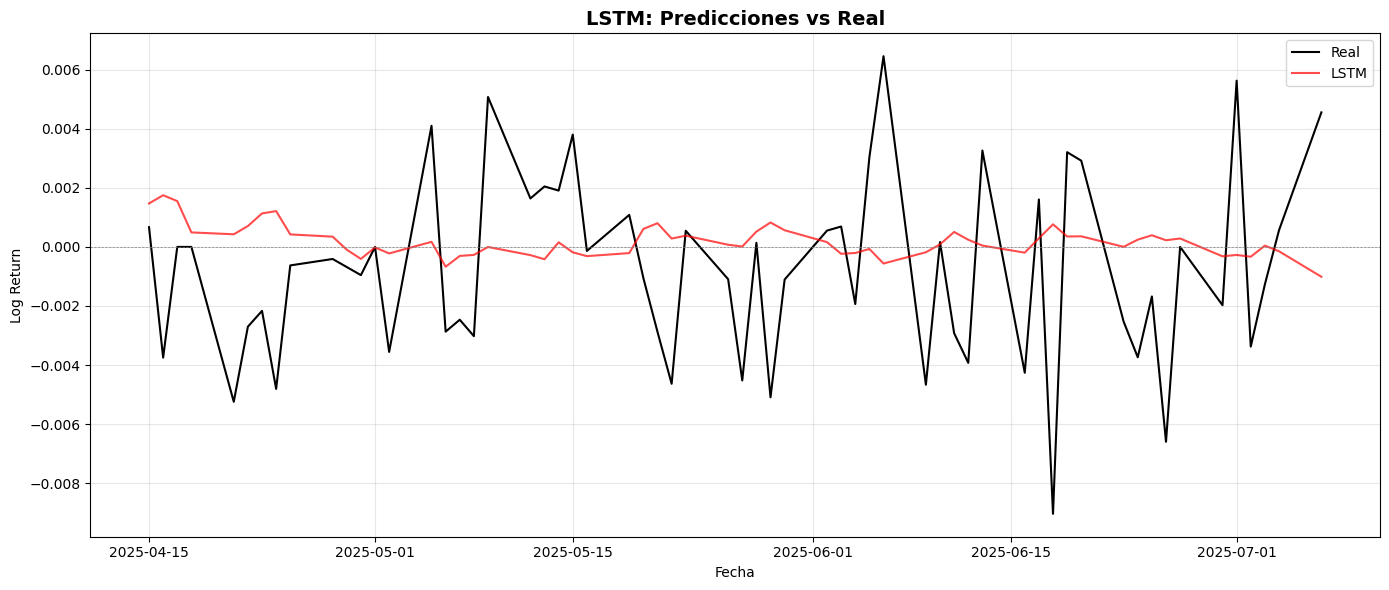

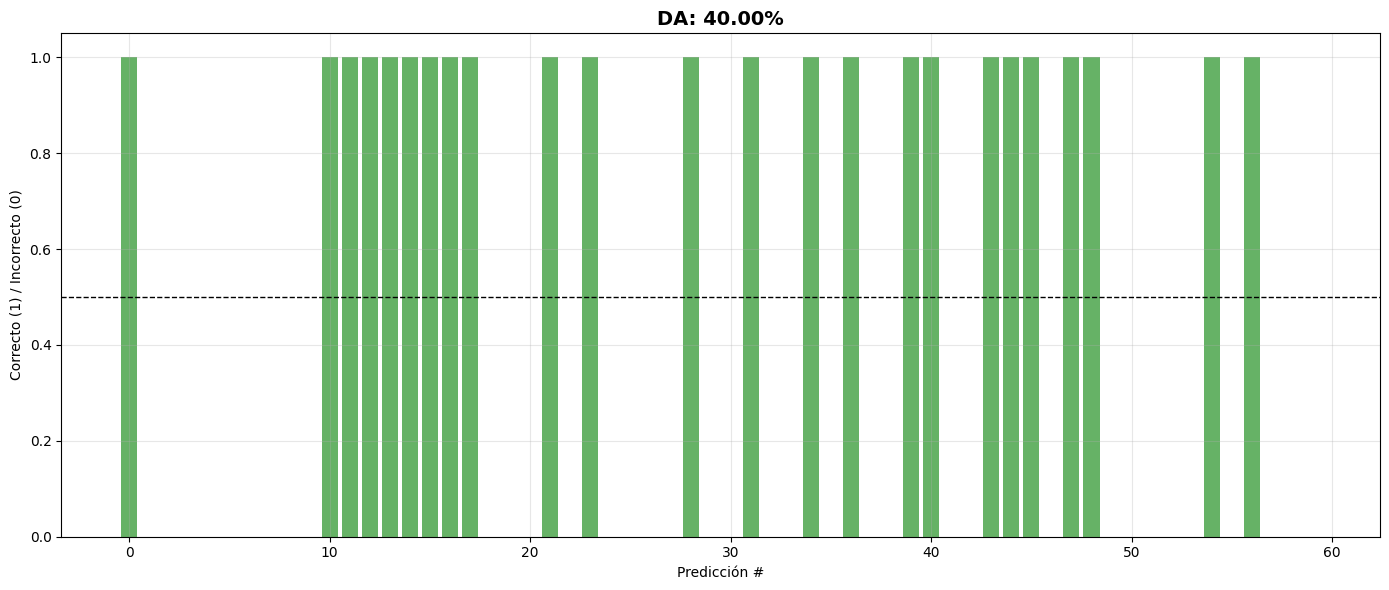

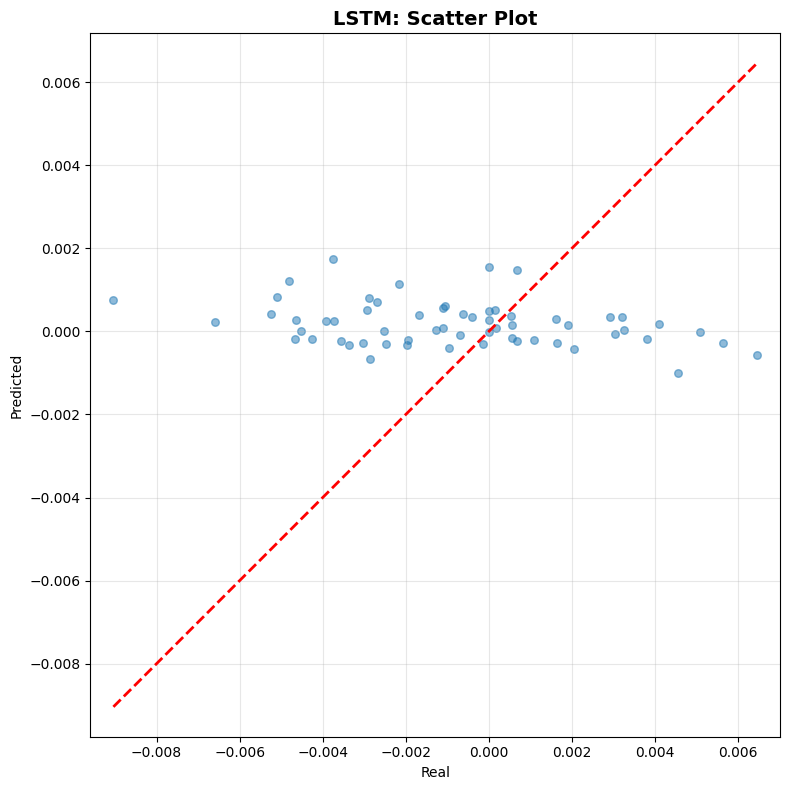


📊 Visualizaciones guardadas en: /content/drive/MyDrive/Colab_Outputs/LSTM_h1_USD_PEN/figs


In [ ]:
# PASO 6: VISUALIZACIONES
# ------------------------
create_visualizations(final_results)

In [ ]:
# PASO 7: GUARDAR TODO
# ---------------------
save_results(final_results, tuning_results)



💾 Modelo: /content/drive/MyDrive/Colab_Outputs/LSTM_h1_USD_PEN/lstm_h1_final.pkl
💾 Métricas: /content/drive/MyDrive/Colab_Outputs/LSTM_h1_USD_PEN/metrics.json
💾 Config: /content/drive/MyDrive/Colab_Outputs/LSTM_h1_USD_PEN/config.json


In [ ]:
# PASO 8: EXPORTAR PARA META-LEARNER
# -----------------------------------
export_file = export_model_predictions(
    dates=final_results['predictions']['dates'],
    y_pred=final_results['predictions']['y_pred_returns'],
    model_name='LSTM',
    prediction_type='log_returns'
)


💾 EXPORTACIÓN:
   Archivo: /content/drive/MyDrive/Colab_Outputs/predictions_dump/pred_LSTM.csv
   Shape: (60, 4)
   Tipo: log_returns
   Predicciones: 60
   ✅ Número correcto


In [ ]:
# PASO 9: RESUMEN FINAL (MODIFICADO)
# ----------------------
print("\n" + "="*80)
print("✅ PIPELINE COMPLETADO")
print("="*80)

print(f"\n📊 RESULTADOS HOLDOUT:")
print(f"   DA:   {final_results['holdout_metrics']['DA']:.2f}%")
print(f"   MASE: {final_results['holdout_metrics']['MASE']:.4f}")
print(f"   MAE:  {final_results['holdout_metrics']['MAE']:.6f}")

print(f"\n📊 RESULTADOS OOF (para Meta-Learner):")
print(f"   DA OOF:   {oof_results['metrics']['da']:.2f}%")
print(f"   MASE OOF: {oof_results['metrics']['mase']:.4f}")
print(f"   Observaciones OOF: {len(oof_results['predictions'])}")

print(f"\n📁 ARCHIVOS EN DRIVE:")
print(f"   Modelo:      {OUTPUT_DIR}/lstm_h1_final.pkl")
print(f"   Métricas:    {OUTPUT_DIR}/metrics.json")
print(f"   Config:      {OUTPUT_DIR}/config.json")
print(f"   Figs:        {OUTPUT_DIR}/figs/")
print(f"   Holdout:     {export_file}")
print(f"   OOF Train:   {OOF_DIR}/train_oof_LSTM.csv")  # ← NUEVO

print("\n🎉 ¡LSTM COMPLETADO Y LISTO PARA ENSEMBLE!")
print("   ✅ Predicciones holdout (60 obs) exportadas")
print("   ✅ Predicciones OOF (~7,600 obs) exportadas")

# ============================================================================
# FIN DEL NOTEBOOK
# ============================================================================
















✅ PIPELINE COMPLETADO

📊 RESULTADOS HOLDOUT:
   DA:   40.00%
   MASE: 1.0058
   MAE:  0.002798

📊 RESULTADOS OOF (para Meta-Learner):
   DA OOF:   49.83%
   MASE OOF: 0.8386
   Observaciones OOF: 7867

📁 ARCHIVOS EN DRIVE:
   Modelo:      /content/drive/MyDrive/Colab_Outputs/LSTM_h1_USD_PEN/lstm_h1_final.pkl
   Métricas:    /content/drive/MyDrive/Colab_Outputs/LSTM_h1_USD_PEN/metrics.json
   Config:      /content/drive/MyDrive/Colab_Outputs/LSTM_h1_USD_PEN/config.json
   Figs:        /content/drive/MyDrive/Colab_Outputs/LSTM_h1_USD_PEN/figs/
   Holdout:     /content/drive/MyDrive/Colab_Outputs/predictions_dump/pred_LSTM.csv
   OOF Train:   /content/drive/MyDrive/Colab_Outputs/oof_predictions/train_oof_LSTM.csv

🎉 ¡LSTM COMPLETADO Y LISTO PARA ENSEMBLE!
   ✅ Predicciones holdout (60 obs) exportadas
   ✅ Predicciones OOF (~7,600 obs) exportadas
